## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [38]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train
%matplotlib inline

In [39]:
torch.manual_seed(7)

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [153]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=8)

In [41]:
images_train, labels_train = next(iter(train_loader))

In [42]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

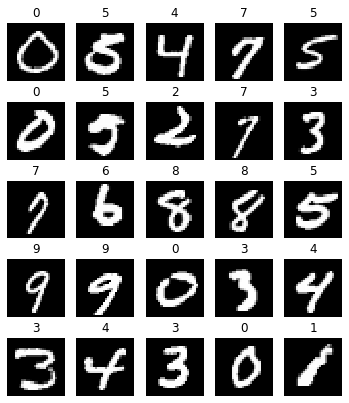

In [44]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [45]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [46]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [52]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)
    
def He_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    weight.normal_(mean=0, std=np.sqrt(2/weight.size()[0]))

init_f = dumb_init
    
net = []
net.append(make_linear(28*28, 500, init_f))
for i in range(8):
    net.append(make_linear(500, 500, init_f))
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9946251511573792
forward 28.22020721435547
forward 630.9122314453125
forward 13969.48828125
forward 315633.65625
forward 7075025.0
forward 157688912.0
forward 3525882880.0
forward 77970956288.0
forward 1728524451840.0
backward 0.021602464839816093
backward 0.3316876292228699
backward 7.68322229385376
backward 168.388427734375
backward 3694.72119140625
backward 78085.203125
backward 1785120.125
backward 40404428.0
backward 927733824.0
backward 20097986560.0


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [53]:
init_f = xavier_init
    
net = []
net.append(make_linear(28*28, 500, init_f))
for i in range(8):
    net.append(make_linear(500, 500, init_f))
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9946251511573792
forward 1.1018311977386475
forward 1.1018341779708862
forward 1.0995111465454102
forward 1.0978057384490967
forward 1.0750361680984497
forward 1.0814138650894165
forward 1.066542625427246
forward 1.0762250423431396
forward 1.0631976127624512
backward 0.021602464839816093
backward 0.020542379468679428
backward 0.020215919241309166
backward 0.02029452659189701
backward 0.02003464661538601
backward 0.02063543163239956
backward 0.02118176780641079
backward 0.021386634558439255
backward 0.021177133545279503
backward 0.020337965339422226


<i> 1.4 Сделайте выводы по первой части </i>

In [55]:
init_f = He_init
    
net = []
net.append(make_linear(28*28, 500, init_f))
for i in range(8):
    net.append(make_linear(500, 500, init_f))
    net.append(nn.ReLU())
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9946251511573792
forward 1.753541111946106
forward 1.5091522932052612
forward 1.5196475982666016
forward 1.5889910459518433
forward 1.6327168941497803
forward 1.6616175174713135
forward 1.6510199308395386
forward 1.7381231784820557
forward 1.7547603845596313
backward 0.021602464839816093
backward 0.09019290655851364
backward 0.08709770441055298
backward 0.0765075609087944
backward 0.0746193453669548
backward 0.07289876788854599
backward 0.07042976468801498
backward 0.061238035559654236
backward 0.053398653864860535
backward 0.07146581262350082


### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [64]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()        
        self.lin = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.ones_like(self.lin.weight) * self.p
        
        if self.training:
            mask = torch.ones_like(self.lin.weight) * self.p
            mask.bernoulli_()
            
        mask.detach_()

        output = torch.mm(x, (self.lin.weight*mask).transpose(0, 1))+self.lin.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [151]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    #net.append(DropConnect(in_dim, out_dim))
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

In [152]:
# %%time
# train(net, train_loader, test_loader, 5, 0.01)

#### Сравнение

Epoch 19... (Train/Test) NLL: 0.009/0.097	Accuracy: 0.997/0.981


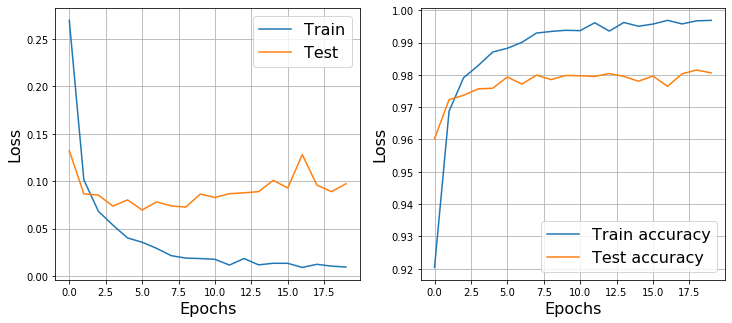

CPU times: user 10min 37s, sys: 8min 54s, total: 19min 32s
Wall time: 3min 39s


([0.2697794631139429,
  0.10143492678637063,
  0.06824338470281822,
  0.05362354872573508,
  0.040129422654967696,
  0.03560595388270057,
  0.029117019107587128,
  0.021414689969386596,
  0.018831428177634887,
  0.01838238811309535,
  0.017559720831029593,
  0.011518781366089715,
  0.018386620732585537,
  0.01170905446286188,
  0.013390645920990908,
  0.013352886436112809,
  0.008988035779131062,
  0.012283250018997561,
  0.010376324034714227,
  0.009385877750794615],
 [0.13229664174627653,
  0.08660600548963758,
  0.0853476932720293,
  0.07373073668796805,
  0.08027753202079595,
  0.06966028897138903,
  0.07822585900467408,
  0.07396757564967192,
  0.07266708056418862,
  0.08646934137597115,
  0.08281178757418654,
  0.08685477940539559,
  0.08773533152077417,
  0.08901317114941776,
  0.10089435598583114,
  0.09289345328745438,
  0.12808909606265165,
  0.0959833210040933,
  0.0889587953091375,
  0.09736354878508262],
 [0.9203758,
  0.96878886,
  0.9791389,
  0.98289245,
  0.9870791,
  

In [155]:
%%time
network = nn.Sequential(nn.Linear(784, 200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

Epoch 19... (Train/Test) NLL: 0.101/0.074	Accuracy: 0.970/0.979


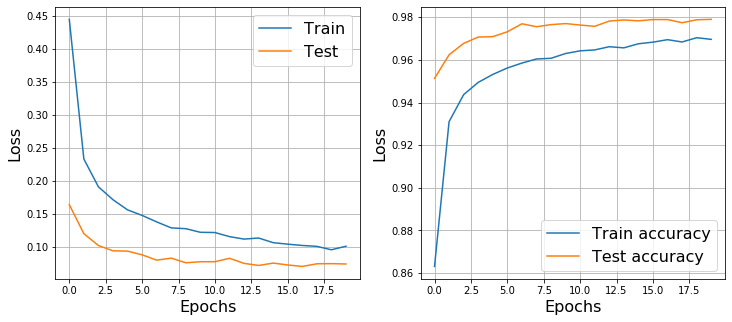

CPU times: user 10min 49s, sys: 8min 58s, total: 19min 47s
Wall time: 3min 38s


([0.44427718959256274,
  0.23301697382604136,
  0.1909174182807713,
  0.17144490984171185,
  0.15605581762281054,
  0.14769027477451988,
  0.13788848080392332,
  0.12881457349702494,
  0.12757534567099899,
  0.12213181180438634,
  0.1217713630490148,
  0.11558088261896232,
  0.11184517167278253,
  0.11348695545864385,
  0.10641974956194349,
  0.10417967804892263,
  0.10219994383548368,
  0.1008372332479781,
  0.09568438526671896,
  0.10103305366470107],
 [0.16395246129058585,
  0.12005837101347838,
  0.10213271125302284,
  0.09408147124974411,
  0.09364331129325341,
  0.08803723859777556,
  0.0799995115427654,
  0.08303935861191418,
  0.07603046270912583,
  0.07760628090016072,
  0.07762231873466244,
  0.08281235906142223,
  0.07511937296418827,
  0.0719700579625802,
  0.07554172821743768,
  0.07271719663227096,
  0.07046303225539718,
  0.0744830735066104,
  0.0746980226256802,
  0.07419774337094041],
 [0.86312854,
  0.9310423,
  0.94372445,
  0.9494658,
  0.9531972,
  0.9562122,
  0.9

In [156]:
%%time
network = nn.Sequential(nn.Linear(784, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

Epoch 19... (Train/Test) NLL: 0.060/0.075	Accuracy: 0.980/0.978


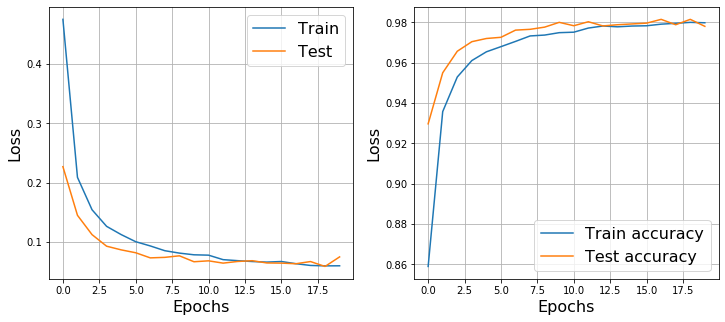

CPU times: user 15min 6s, sys: 11min 53s, total: 26min 59s
Wall time: 4min 45s


([0.47576636741601075,
  0.20893826954432135,
  0.15424072457306676,
  0.12620628152940191,
  0.11230086323135952,
  0.10027127116839134,
  0.09312553941480704,
  0.08505542253626626,
  0.08100792975711034,
  0.07816805651208866,
  0.07755623376374242,
  0.06997086897567868,
  0.06825750712543599,
  0.06680112714960632,
  0.06583333416665191,
  0.06683344870601207,
  0.06312769879676354,
  0.06018344153896339,
  0.059463468552040835,
  0.059600268260264065],
 [0.22698838603270205,
  0.14482398052947432,
  0.11223187974265104,
  0.09268815815448761,
  0.08650090288418004,
  0.08160676771798465,
  0.07297048860382807,
  0.07384123489160468,
  0.07646158285721948,
  0.06643105415727565,
  0.06796781022596775,
  0.06410734234024075,
  0.06690005359793955,
  0.06818971999838383,
  0.06440052077692898,
  0.0641170217551249,
  0.06304508494213223,
  0.06675282573398156,
  0.058493623389166936,
  0.07463371343439139],
 [0.85895854,
  0.93575096,
  0.952914,
  0.96106523,
  0.9654129,
  0.96797

In [157]:
%%time
network = nn.Sequential(DropConnect(784, 200, p=0.5),
                        nn.ReLU(),
                        DropConnect(200, 200, p=0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

<i> 2.3 Сделайте выводы по третьей части </i>

>В итоге видно, что сеть без Dropout и Dropconnect перестала обучаться довольно быстро.  В то время как с ними - точность на тесте продолжает расти почти до 20й эпохи, т.к Dropout и Dropconnect уменьшают переобучение.

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [158]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(1, keepdim=True)) / (x.std(1, keepdim=True) + 1e-5)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 19... (Train/Test) NLL: 0.009/0.073	Accuracy: 0.997/0.981


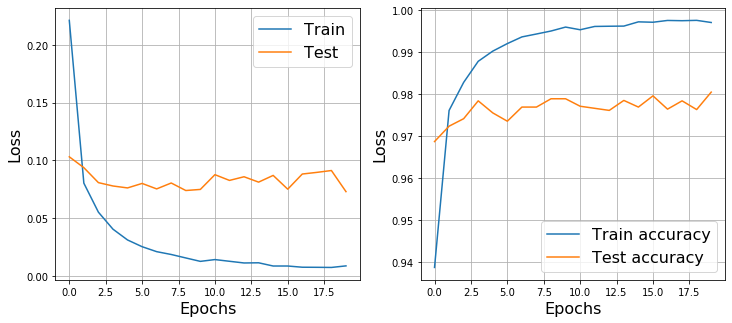

CPU times: user 14min 19s, sys: 10min 17s, total: 24min 36s
Wall time: 4min 21s


([0.22102865343615571,
  0.0803518159382506,
  0.05527434150563247,
  0.04059013459525669,
  0.03127461858242671,
  0.025456262832837126,
  0.021163753875499482,
  0.01872171428841926,
  0.015730393991154282,
  0.012776796199651415,
  0.014323313161780411,
  0.01285013083099469,
  0.011392572300825347,
  0.011545413080218142,
  0.00876204491849107,
  0.008764758710653882,
  0.0077187916178798385,
  0.0076478945057174424,
  0.007524935499780369,
  0.008876609695629268],
 [0.10312251204365416,
  0.09374532089391842,
  0.080806785498899,
  0.07790970094973527,
  0.07623891228857109,
  0.08012027544547108,
  0.07539488442530974,
  0.08048732212709286,
  0.07399963432203836,
  0.07493912529412515,
  0.0876896058362496,
  0.08273270683174458,
  0.08588812242651099,
  0.08124518970062933,
  0.0870516635359654,
  0.07515556745443351,
  0.08824969951912195,
  0.08966994777769793,
  0.09126982028165809,
  0.07302588207759199],
 [0.93878263,
  0.9761572,
  0.98283136,
  0.98785096,
  0.9902774,
 

In [159]:
%%time
network = nn.Sequential(nn.Linear(784, 200),
                        nn.BatchNorm1d(200, eps=1e-5, track_running_stats=False, affine=False, momentum=None),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(200, eps=1e-5, track_running_stats=False, affine=False, momentum=None),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax()
                       )
train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

In [160]:
# полезные функции: .std(dim), .mean(dim)

class my_BatchNorm(nn.Module):
    def forward(self, x):
        output = (x - x.mean((0,1),keepdim=True)) / (x.std((0,1),keepdim=True) + 1e-5)
        return output

Epoch 19... (Train/Test) NLL: 0.007/0.075	Accuracy: 0.998/0.980


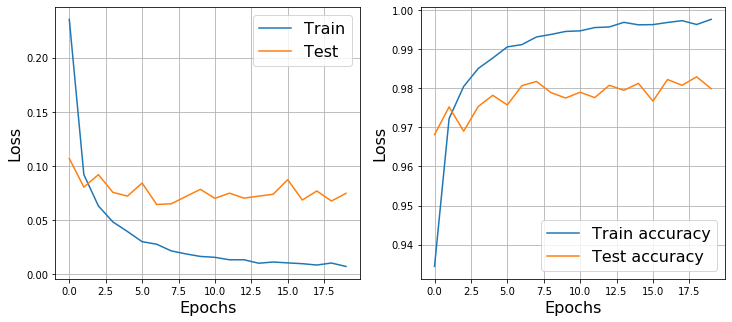

CPU times: user 12min 23s, sys: 10min 6s, total: 22min 29s
Wall time: 4min 4s


([0.23537450161442827,
  0.09210288448771561,
  0.06309439325685313,
  0.04828178940881004,
  0.03948065366790588,
  0.030143209209324104,
  0.027778642822001407,
  0.021645121179820932,
  0.018860358612682385,
  0.01652892902200577,
  0.01568507237460659,
  0.01343395875239157,
  0.013438250652195683,
  0.010253489150067241,
  0.01135244563610148,
  0.010552998862261805,
  0.009820948934059904,
  0.008567410140935736,
  0.010430432860240606,
  0.007271653061411453],
 [0.1069290006321065,
  0.08049596129338953,
  0.09200926247654082,
  0.07559456817711456,
  0.07224381935511585,
  0.08428016552536548,
  0.06447183136840033,
  0.06509240331788417,
  0.07178336652614695,
  0.07844831868770379,
  0.07016802721810114,
  0.0749225398331079,
  0.0703155982007473,
  0.07217299022794335,
  0.0739031101523934,
  0.08739126406910629,
  0.06861495565257589,
  0.0769276406727967,
  0.06766896433848298,
  0.07475556790404304],
 [0.93437946,
  0.9722593,
  0.9805049,
  0.98511904,
  0.98780096,
  0.

In [161]:
%%time
network = nn.Sequential(nn.Linear(784, 200),
                        my_BatchNorm(),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        my_BatchNorm(),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax()
                       )
train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

Epoch 19... (Train/Test) NLL: 0.010/0.075	Accuracy: 0.997/0.983


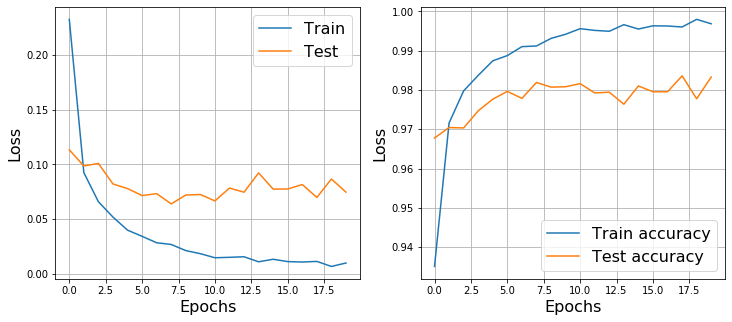

CPU times: user 11min 17s, sys: 9min 15s, total: 20min 33s
Wall time: 3min 43s


([0.23229016006183523,
  0.09240836338765586,
  0.06585317972932321,
  0.05184804064743936,
  0.039936280911609626,
  0.034291988093235186,
  0.028409059355551724,
  0.02686299007437599,
  0.021280604592367594,
  0.01846728630826624,
  0.014740881995473708,
  0.015143112625493838,
  0.01564893809366606,
  0.01106408248752428,
  0.013361113105239327,
  0.011243747131872192,
  0.010837798039163293,
  0.011399638045288528,
  0.006811593032380537,
  0.009936016196898097],
 [0.11323093028762672,
  0.09852333538988724,
  0.1007976196942073,
  0.08205780088076298,
  0.07786426979671174,
  0.0714819498030068,
  0.07323301501006266,
  0.06389221535476891,
  0.0719834560553449,
  0.07246881020196443,
  0.06660643776825664,
  0.07833179437755784,
  0.07456298306204166,
  0.09216509261345372,
  0.07736781611301806,
  0.07749838069600018,
  0.08153954964968128,
  0.06977932350975284,
  0.0866064179741742,
  0.07462657908661041],
 [0.9350791,
  0.97159296,
  0.9797663,
  0.98370314,
  0.98740673,
  

In [162]:
%%time
network = nn.Sequential(nn.Linear(784, 200),
                        nn.LayerNorm(200, elementwise_affine=False),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.LayerNorm(200, elementwise_affine=False),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax()
                       )
train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

Epoch 19... (Train/Test) NLL: 0.012/0.068	Accuracy: 0.996/0.982


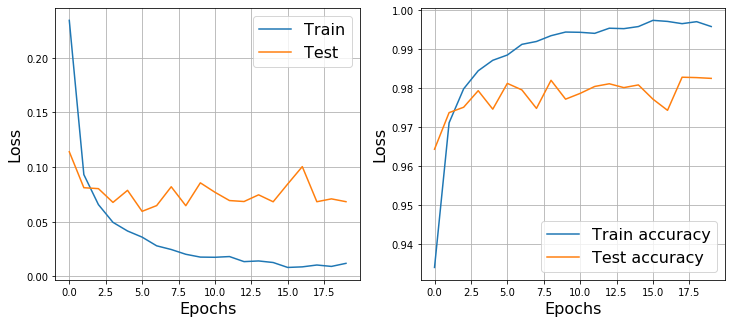

CPU times: user 12min 12s, sys: 9min 55s, total: 22min 7s
Wall time: 4min 3s


([0.23417176697840061,
  0.09313127773800003,
  0.06568955111184291,
  0.04945992708984596,
  0.0415478247393574,
  0.035955280089365646,
  0.02799418894325826,
  0.024627044540780314,
  0.02026092967188268,
  0.017682103737905772,
  0.017519414372521757,
  0.018171002786891505,
  0.013542862704345413,
  0.014157615071073222,
  0.012732787206317228,
  0.008219623566151652,
  0.00875367386540128,
  0.010443837494963705,
  0.009163819383325944,
  0.011968631688700264],
 [0.11400605596696274,
  0.08113286363644691,
  0.0802878671903399,
  0.06770247021760745,
  0.07873604931173069,
  0.05952661788485991,
  0.06478385739853676,
  0.08199428869529238,
  0.06468817888157843,
  0.08558626294053526,
  0.07699000115743602,
  0.0693842670231869,
  0.06850626683628917,
  0.07462269104899297,
  0.06827445544561819,
  0.08453630557566692,
  0.10042961736362946,
  0.06831392535462362,
  0.07092889828557337,
  0.06835594172648425],
 [0.9339241,
  0.97107655,
  0.9798108,
  0.9844472,
  0.9871402,
  0

In [164]:
%%time
network = nn.Sequential(nn.Linear(784, 200),
                        LayerNormalization(),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax()
                       )
train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

<i> 3.3 Сделайте выводы по третьей части </i>

> Между Batch и Layer normalization особой разницы на обучении данной сети я не  замечаю

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: